In [ ]:
!pip install git+https://github.com/abhaskumarsinha/Gaussian-LiteSplat.git
!git clone https://github.com/abhaskumarsinha/Gaussian-LiteSplat.git
%cd Gaussian-LiteSplat

  Cloning https://github.com/abhaskumarsinha/Gaussian-LiteSplat.git to /tmp/pip-req-build-6j7exfo7
  Running command git clone --filter=blob:none --quiet https://github.com/abhaskumarsinha/Gaussian-LiteSplat.git /tmp/pip-req-build-6j7exfo7
  Resolved https://github.com/abhaskumarsinha/Gaussian-LiteSplat.git to commit 1bef98c6714e072bec831618ece47d47b65430d9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for litesplat: filename=litesplat-0.1.0-py3-none-any.whl size=17532 sha256=f34598e6811eed308b3dc509d092565b25fa273e68c9d7620af370a08fd97943
  Stored in directory: /tmp/pip-ephem-wheel-cache-sq32b3ze/wheels/a3/86/9e/ffcd8ca24d8e55a4944ad6ccf2db1046c35aa1cbf349ff4cca
Successfully built litesplat
Cloning into 'Gaussian-LiteSplat'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 221 

In [ ]:
!unzip -o /content/TempleRingNeRF.zip

Archive:  /content/TempleRingNeRF.zip
   creating: temple_ring/
   creating: temple_ring/images/
  inflating: temple_ring/images/templeR0001.png  
  inflating: temple_ring/images/templeR0002.png  
  inflating: temple_ring/images/templeR0003.png  
  inflating: temple_ring/images/templeR0004.png  
  inflating: temple_ring/images/templeR0005.png  
  inflating: temple_ring/images/templeR0006.png  
  inflating: temple_ring/images/templeR0007.png  
  inflating: temple_ring/images/templeR0008.png  
  inflating: temple_ring/images/templeR0009.png  
  inflating: temple_ring/images/templeR0010.png  
  inflating: temple_ring/images/templeR0011.png  
  inflating: temple_ring/images/templeR0012.png  
  inflating: temple_ring/images/templeR0013.png  
  inflating: temple_ring/images/templeR0014.png  
  inflating: temple_ring/images/templeR0015.png  
  inflating: temple_ring/images/templeR0016.png  
  inflating: temple_ring/images/templeR0017.png  
  inflating: temple_ring/images/templeR0018.png  
  i

In [ ]:
import os

# This guide can only be run with the torch backend.
os.environ["KERAS_BACKEND"] = "torch"

In [ ]:
from litesplat.io import convert_colmap_to_gaussians, import_gaussian_scene
from litesplat.core import GaussianParameterLayer
from litesplat.core import CameraLayer
from litesplat.utils import Renderer

import keras
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
colmap_scene = '/content/Gaussian-LiteSplat/temple_ring'
litesplat_scene = 'temple'

total_gaussians=2560
images_dir='/content/Gaussian-LiteSplat/temple_ring/images'
trainable_focus=False
trainable_principal=False
trainable_extrinsics=False
max_gaussians=2560

output_h=int(48*10)
output_w=int(64*10)

output_gaussians='/content/gaussians.JSON'

torch_compile_flag=True

cam_import=45
train_cams=15

lr=1e-2
weight_decay=0
num_epochs=100
batch_size=128
checkpoint=10

num_images=15
cols = 5

output_dir = "output"
dpi=300

In [ ]:
convert_colmap_to_gaussians(colmap_scene, litesplat_scene)

📁 Valid NeRF scene found at: /content/Gaussian-LiteSplat/temple_ring
  - Using COLMAP data from: /content/Gaussian-LiteSplat/temple_ring/sparse/0
  - Using images from: /content/Gaussian-LiteSplat/temple_ring/images
✅ Exported:
→ temple/gaussians.json
→ temple/camera.json


('temple/gaussians.json', 'temple/camera.json')

In [ ]:
gaussians = GaussianParameterLayer(litesplat_scene,
                                   total_gaussians=2200)

📂 Importing Gaussian scene from: temple
🎲 Randomly sampled 2200 / 2200 Gaussians (seed=None, preserve_order=True).


In [ ]:
cams = []
for i in range(45):
    cams.append(CameraLayer(litesplat_scene,
                            gaussians,
                            images_dir,
                            trainable_focus,
                            trainable_principal,
                            trainable_extrinsics,
                            i,
                            max_gaussians,
                            output_h,
                            output_w))

In [ ]:
renderer = Renderer(cams,
                    output_h,
                    output_w,
                    torch_compile_flag)

In [ ]:
import random
cam_ids = [int(i) for i in range(cam_import)]
random.shuffle(cam_ids)
cam_ids = cam_ids[:train_cams]

In [ ]:
import torch
y_real = torch.stack([cams[i].y_real for i in range(train_cams)], dim=0) / 255.0
print(y_real.shape)

torch.Size([15, 72, 96, 3])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_real = y_real.to(device)

# Your renderer (must already be a torch.nn.Module or have callable .call)
renderer = renderer.to(device)

# Optimizer
optimizer = optim.Adam(renderer.parameters(), lr=lr, weight_decay=weight_decay)

# Loss function
criterion = nn.MSELoss()

# Dummy camera IDs for training
cam_ids = torch.arange(train_cams)  # adjust as needed

# Training loop
for epoch in tqdm(range(num_epochs)):
    renderer.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = renderer.call(
        cam_ids,
        output_h,
        output_w,
        render=False,
        bsz=batch_size
    )  # (15, 72, 96, 3)

    # Ensure same dtype and device
    y_pred = y_pred.to(device).float()

    # Compute loss
    loss = criterion(y_pred, y_real)

    # Backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch + 1) % checkpoint == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {loss.item():.6f}")
        for cam in cams:
            cam.get_sorted_keys()
        cams[0].save_gaussians(output_gaussians)

    del y_pred, loss
    torch.cuda.empty_cache()


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/keras/src/backend/torch/core.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return inputs[slices]
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'camera_layer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/backend/torch/core.py:612: UserWarning: Us

Epoch [1/100]  Loss: 0.027516
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [10/100]  Loss: 0.007183
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [20/100]  Loss: 0.005089
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [30/100]  Loss: 0.004083
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [40/100]  Loss: 0.003420
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [50/100]  Loss: 0.002720
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [60/100]  Loss: 0.002304
✅ Saved 2200 Gaussians to /content/gaussians.JSON
Epoch [70/100]  Loss: nan
✅ Saved 2200 Gaussians to /content/gaussians.JSON


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    imgs = renderer.call(cam_ids,
                        output_h,
                        output_w,
                        render = False,
                        bsz=batch_size)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'camera_layer_209', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'camera_layer_218', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'camera_layer_201', however the 

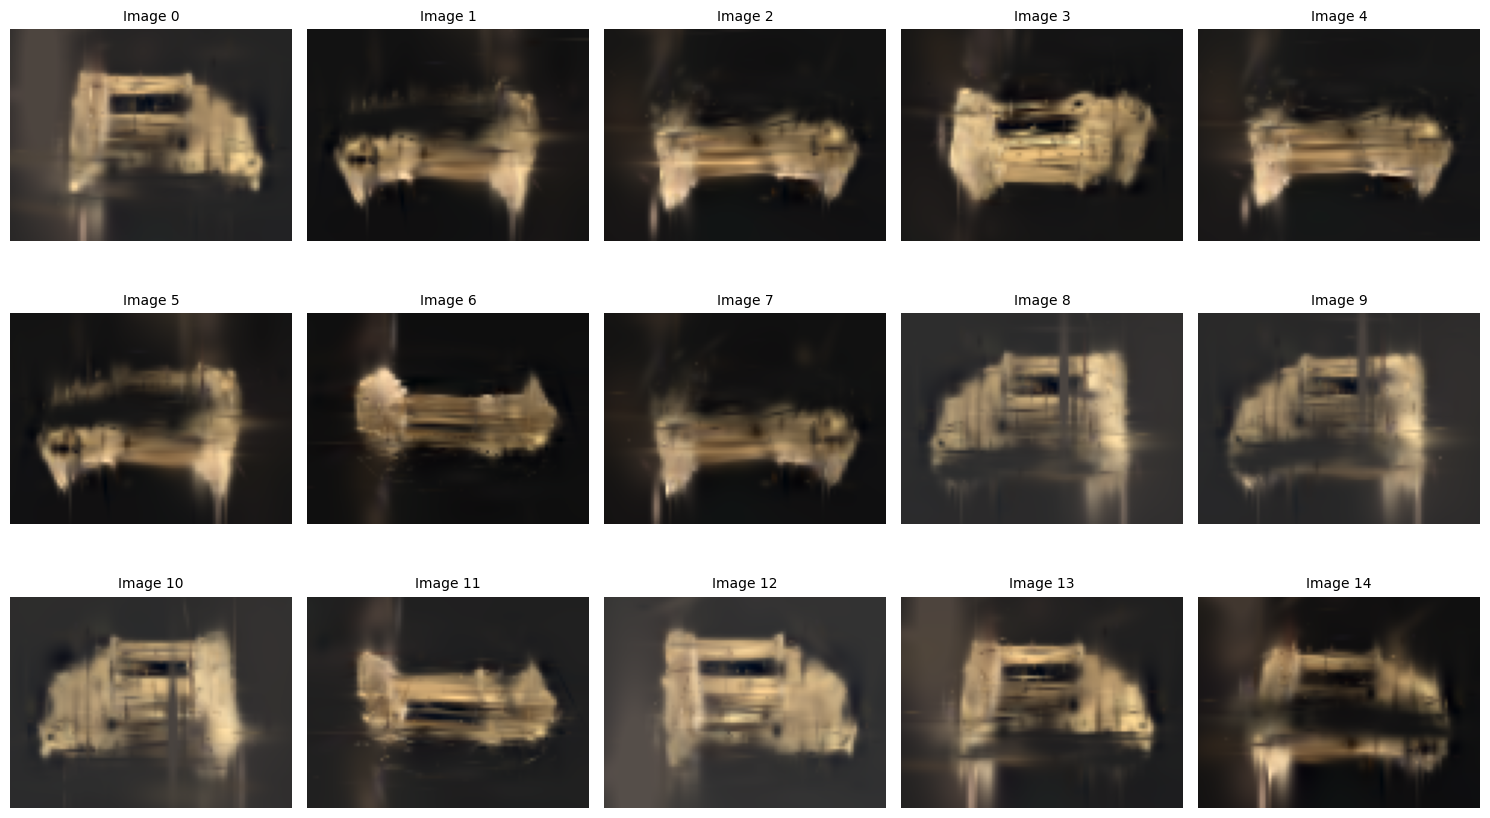

✅ Saved image grid to output/image_grid.png


In [ ]:
rows = int(np.ceil(num_images / cols))
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "image_grid.png")

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        img = imgs[i].detach().cpu().numpy()
        # If image is CHW, transpose to HWC
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            img = np.transpose(img, (1, 2, 0))
        # Normalize to [0,1] if necessary
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        ax.imshow(img)
        ax.set_title(f"Image {i}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.savefig(output_path, dpi=dpi, bbox_inches="tight")
plt.show()

print(f"✅ Saved image grid to {output_path}")


In [ ]:
plt.imshow(imgs[15].detach().cpu().numpy())

IndexError: index 15 is out of bounds for dimension 0 with size 15